<center>
<img src="../../img/ods_stickers.jpg">

## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course
    
Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Assignment #2 (demo)
## <center>Analyzing cardiovascular disease data 
    
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data) + [solution](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data-solution).**

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24).

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
# ticker is the 'tick' points for labeling
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
df = pd.read_csv("../../data/mlbootcamp5_train.csv", sep=";")

print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

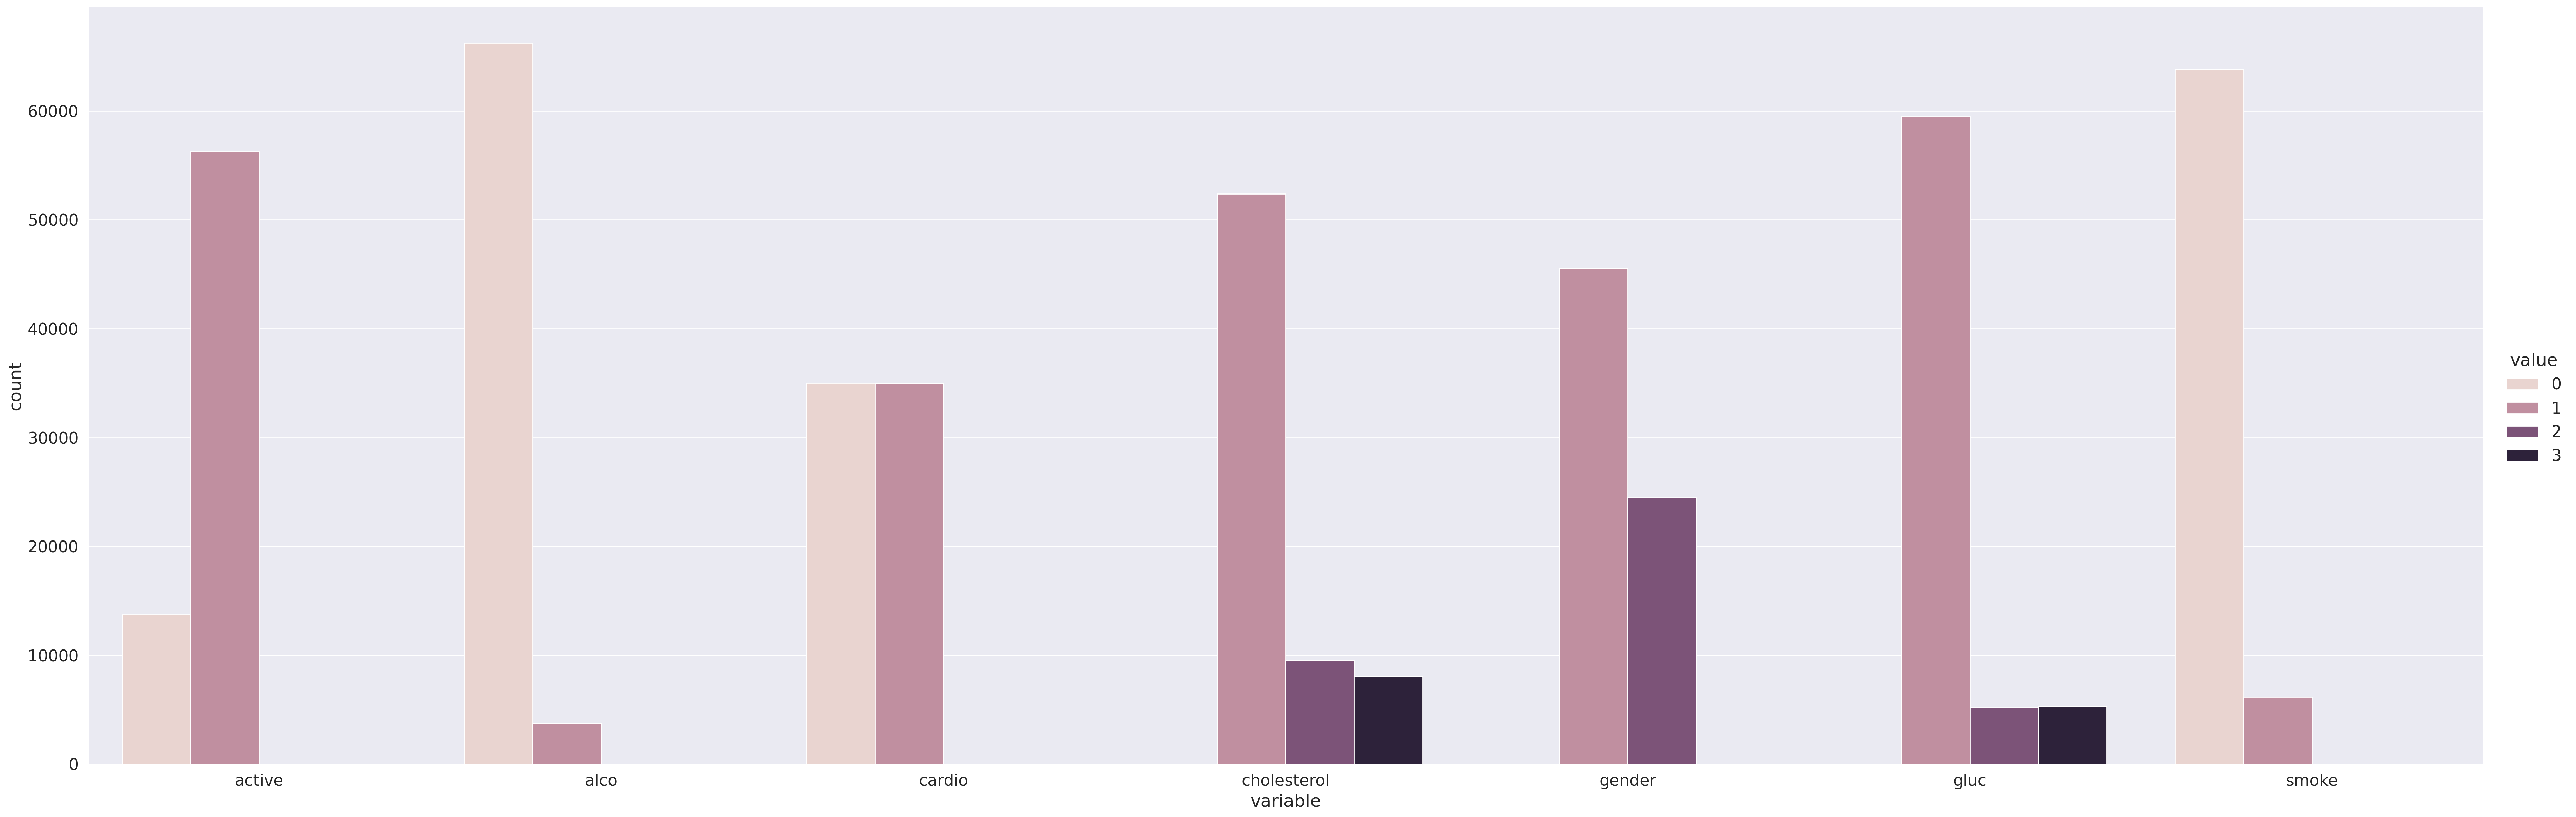

In [4]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

# factor­plot() (depre­cated, use catplot() instead)
# OG rejection of -> AttributeError: Rectangle.set() got an unexpected keyword argument 'size'  
# size changes to height and aspect = width RELATIVE to height * aspect
# HERE I added the 'aspect' to show what would happen.. a aspect = 6 makes it SUPER long and skinny (horizontally) and an aspect =3 makes it fat and long
# this is because the aspect = 6 is giving more 7:7  vibes if you look closely ;)
sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", height=12, aspect=3
);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

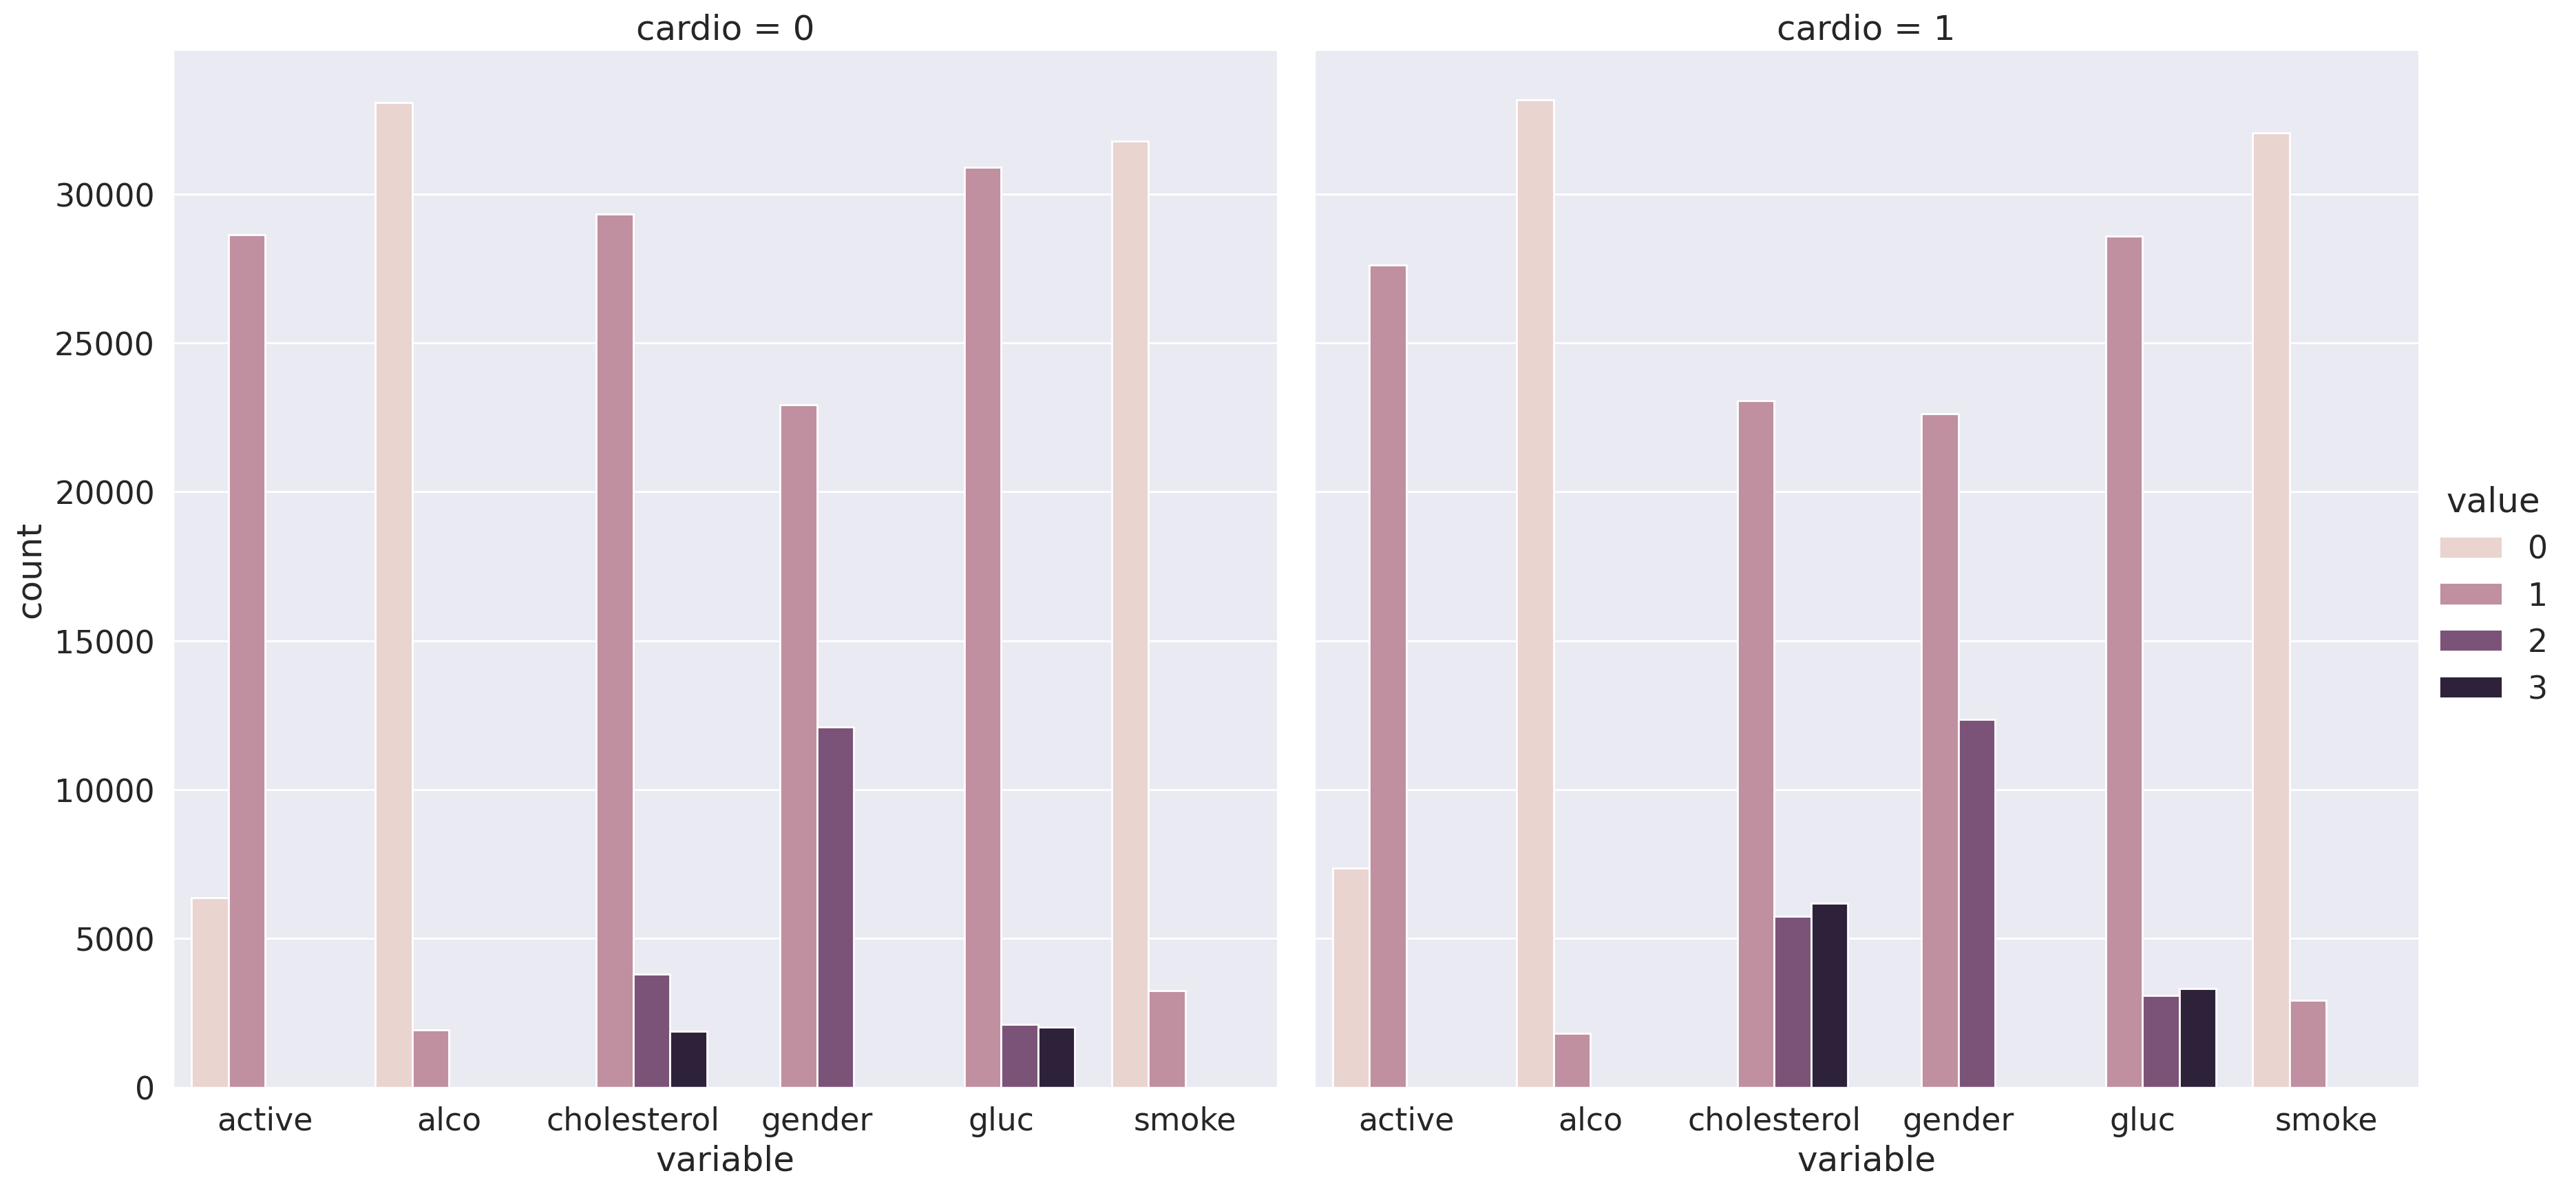

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

# AGAIN the factorplot is deprecated
# size gets changed to height for this to run
sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    height=9,
);

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

In [7]:
df.groupby("gender")["height"].mean()


gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [8]:
# 1 is assumed to be FEMALE
# 2 is assumed to be MALE
# SUCH THAT:
# gender
# 2 [(1, 45530), (2, 24470)]

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. **
1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

In [9]:
# The dataset provided gender
# Females = [(1, 45530),Males = (2, 24470)]
# ANSWER IS 1.

**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men

In [10]:
df.groupby("gender")["alco"].mean()

gender
1    0.025500
2    0.106375
Name: alco, dtype: float64

In [11]:
# Group 2 (Males) consume more alcohol

**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20
4. 24

In [12]:
percentages_of_smokers = df.groupby("gender")["smoke"].mean() * 100
print(percentages_of_smokers)


gender
1     1.785636
2    21.888026
Name: smoke, dtype: float64


In [13]:
# FEMALES = 3.1% MALES = 24.5%

**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

In [14]:
#DIFFERENCE OF median value of age for smokers and non-smokers (in months rounded)
#Age	Objective Feature	age	int (days)
# since this is done in days we will need to calc this by median divide it by num of days in a year and * by 12
# also need to rem that it is the DIFF between the median age,so smokers age - non smokers age THEN do the above

df.groupby("smoke")["age"].median() / 365.25
(
    df[df["smoke"] == 0]["age"].median() - df[df["smoke"] == 1]["age"].median()
    ) / 365.25 * 12


19.613963039014372

In [15]:
# Approx 19.613963039014372
# ANSWER = 4. 20

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src='../../img/SCORE_CVD_eng.png' width=70%>

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [16]:
# Calculate age_years feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
# Age	Objective Feature	age	int (days)
df["age_years"] = (df["age"] / 365.25).round().astype("int")


In [17]:
df["age_years"].max()

65

In [18]:
# For this task, select only the people of age 60 to 64, inclusive
# we have either smoker or non-smoker, male, with cholesterol levels of:
# Cholesterol level categories differ between the figure and our dataset. The conversion for the cholesterol feature is as follows: 4 mmol/l 5-7 mmol/l 8 mmol/l  
smoking_male = df[
    (df["gender"] == 2) & 
    (df["age_years"] >= 60) & 
    (df["age_years"] < 65) & 
    (df["smoke"] == 1)
]



In [19]:
smoking_male[
    (smoking_male["cholesterol"] == 1) & (smoking_male["ap_hi"] < 120)]["cardio"].mean()



0.2631578947368421

In [20]:
smoking_male[ 
    (smoking_male["cholesterol"] == 3) & 
    (smoking_male["ap_hi"] >= 160) & 
    (smoking_male["ap_hi"] < 180)  
]["cardio"].mean()


0.8636363636363636

In [21]:
fraction_1 = 0.2631578947368421
fraction_2 = 0.8636363636363636

ratio = fraction_2 / fraction_1 

print(f"Ratio: {round(ratio, 2)}")

Ratio: 3.28


**Question 1.5. (2 points). Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?**

1. 1
2. 2
3. 3
4. 4

In [22]:
# ANSWER = 3 -> 3.28

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [23]:
# Create a new feature called BMI
# Height	Objective Feature	height	int (cm)
# Weight	Objective Feature	weight	float (kg)
# BMI = Weight (kg) / Height (m)^2
# Normal = 18.5 - 25



# convert height from cm to m
df["height_meters"] = df["height"] / 100

# use the BMI formula
df["BMI"] = df["weight"] / df["height_meters"] ** 2

# verify calculations
print(df[["height", "weight", "BMI"]].head())


   height  weight        BMI
0     168    62.0  21.967120
1     156    85.0  34.927679
2     165    64.0  23.507805
3     169    82.0  28.710479
4     156    56.0  23.011177


**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values.
2. The BMI for women is on average higher than for men.
3. Healthy people have, on average, a higher BMI than the people with CVD.
4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [24]:
# run the BMI against entire dataset
median_bmi = df["BMI"].median()
print(f"Median BMI: {median_bmi}")


Median BMI: 26.374068120774975


In [25]:
# W/M 1=F  2=M
gender_bmi_mean = df.groupby("gender")["BMI"].mean()
print(gender_bmi_mean)


gender
1    27.987583
2    26.754442
Name: BMI, dtype: float64


In [26]:
# healthy have higher BMI vs people w/ CVD 0=health 1=CVD
cardio_bmi_mean = df.groupby("cardio")["BMI"].mean()
print(cardio_bmi_mean)


cardio
0    26.548175
1    28.566061
Name: BMI, dtype: float64


In [27]:
# Compute median BMI grouped by gender, alcohol consumption, and cardiovascular disease status
bmi_median_by_group = df.groupby(["gender", "alco", "cardio"])["BMI"].median().to_frame()

# Display results
print(bmi_median_by_group)

# results are listed under 0,0

                          BMI
gender alco cardio           
1      0    0       25.654372
            1       27.885187
       1    0       27.885187
            1       30.110991
2      0    0       25.102391
            1       26.674874
       1    0       25.351541
            1       27.530797


In [28]:
# The BMI for women is on average higher than for men.
# For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women
# ANSWER = 2,4

## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [29]:
# diastolic pressure is higher than systolic
# this means that sys pressure, or ap_hi, should be > than dias pressure, ap_lo

df_clean = df[df["ap_lo"] <= df["ap_hi"]]

In [30]:
# found documentation here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.quantile.html
#height is strictly less than 2.5 percentile
height_low = df["height"].quantile(0.025)

# height is strictly more than 97.5 percentile
height_high = df["height"].quantile(0.975)

#weight is strictly less than 2.5 percentile
weight_low = df["weight"].quantile(0.025) 

#weight is strictly more than 97.5 percentile
weight_high = df["weight"].quantile(0.975) 

In [31]:
df_clean = df_clean[
    (df_clean["height"] >= height_low) & (df_clean["height"] <= height_high) &
    (df_clean["weight"] >= weight_low) & (df_clean["weight"] <= weight_high)
]


In [32]:
print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_clean.shape[0]}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")


Original dataset size: 70000
Cleaned dataset size: 63259
Rows removed: 6741


**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

In [33]:
#What percent of the original data (rounded) did we throw away?
# ANSWER 9.63% 

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

In [34]:
#check to see if OG dataset is being used
print(f"Dataset size before correlation matrix: {df.shape[0]} rows")
# if we WANTED to use the filtered dataset we would use: corr_matrix_cleaned = df_cleaned.corr()

Dataset size before correlation matrix: 70000 rows


In [35]:
# this is correct, checking the OG Dataset size:  (70000, 13)

In [36]:
# gives correlation metrics
df.corr()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,height_meters,BMI
id,1.000000,0.003457,0.003502,-0.003038,-0.001830,0.003356,-0.002529,0.006106,0.002467,-0.003699,0.001210,0.003755,0.003799,0.003048,-0.003038,-0.001377
age,0.003457,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159,0.999089,-0.081515,0.085512
gender,0.003502,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109,-0.022905,0.499033,-0.096529
height,-0.003038,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821,-0.081349,1.000000,-0.290642
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660,0.053574,0.290968,0.762009
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475,0.020458,0.005488,0.024852
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719,0.017603,0.006150,0.035345
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147,0.154383,-0.050226,0.146270
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307,0.098443,-0.018595,0.101390
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486,-0.047867,0.187989,-0.027215


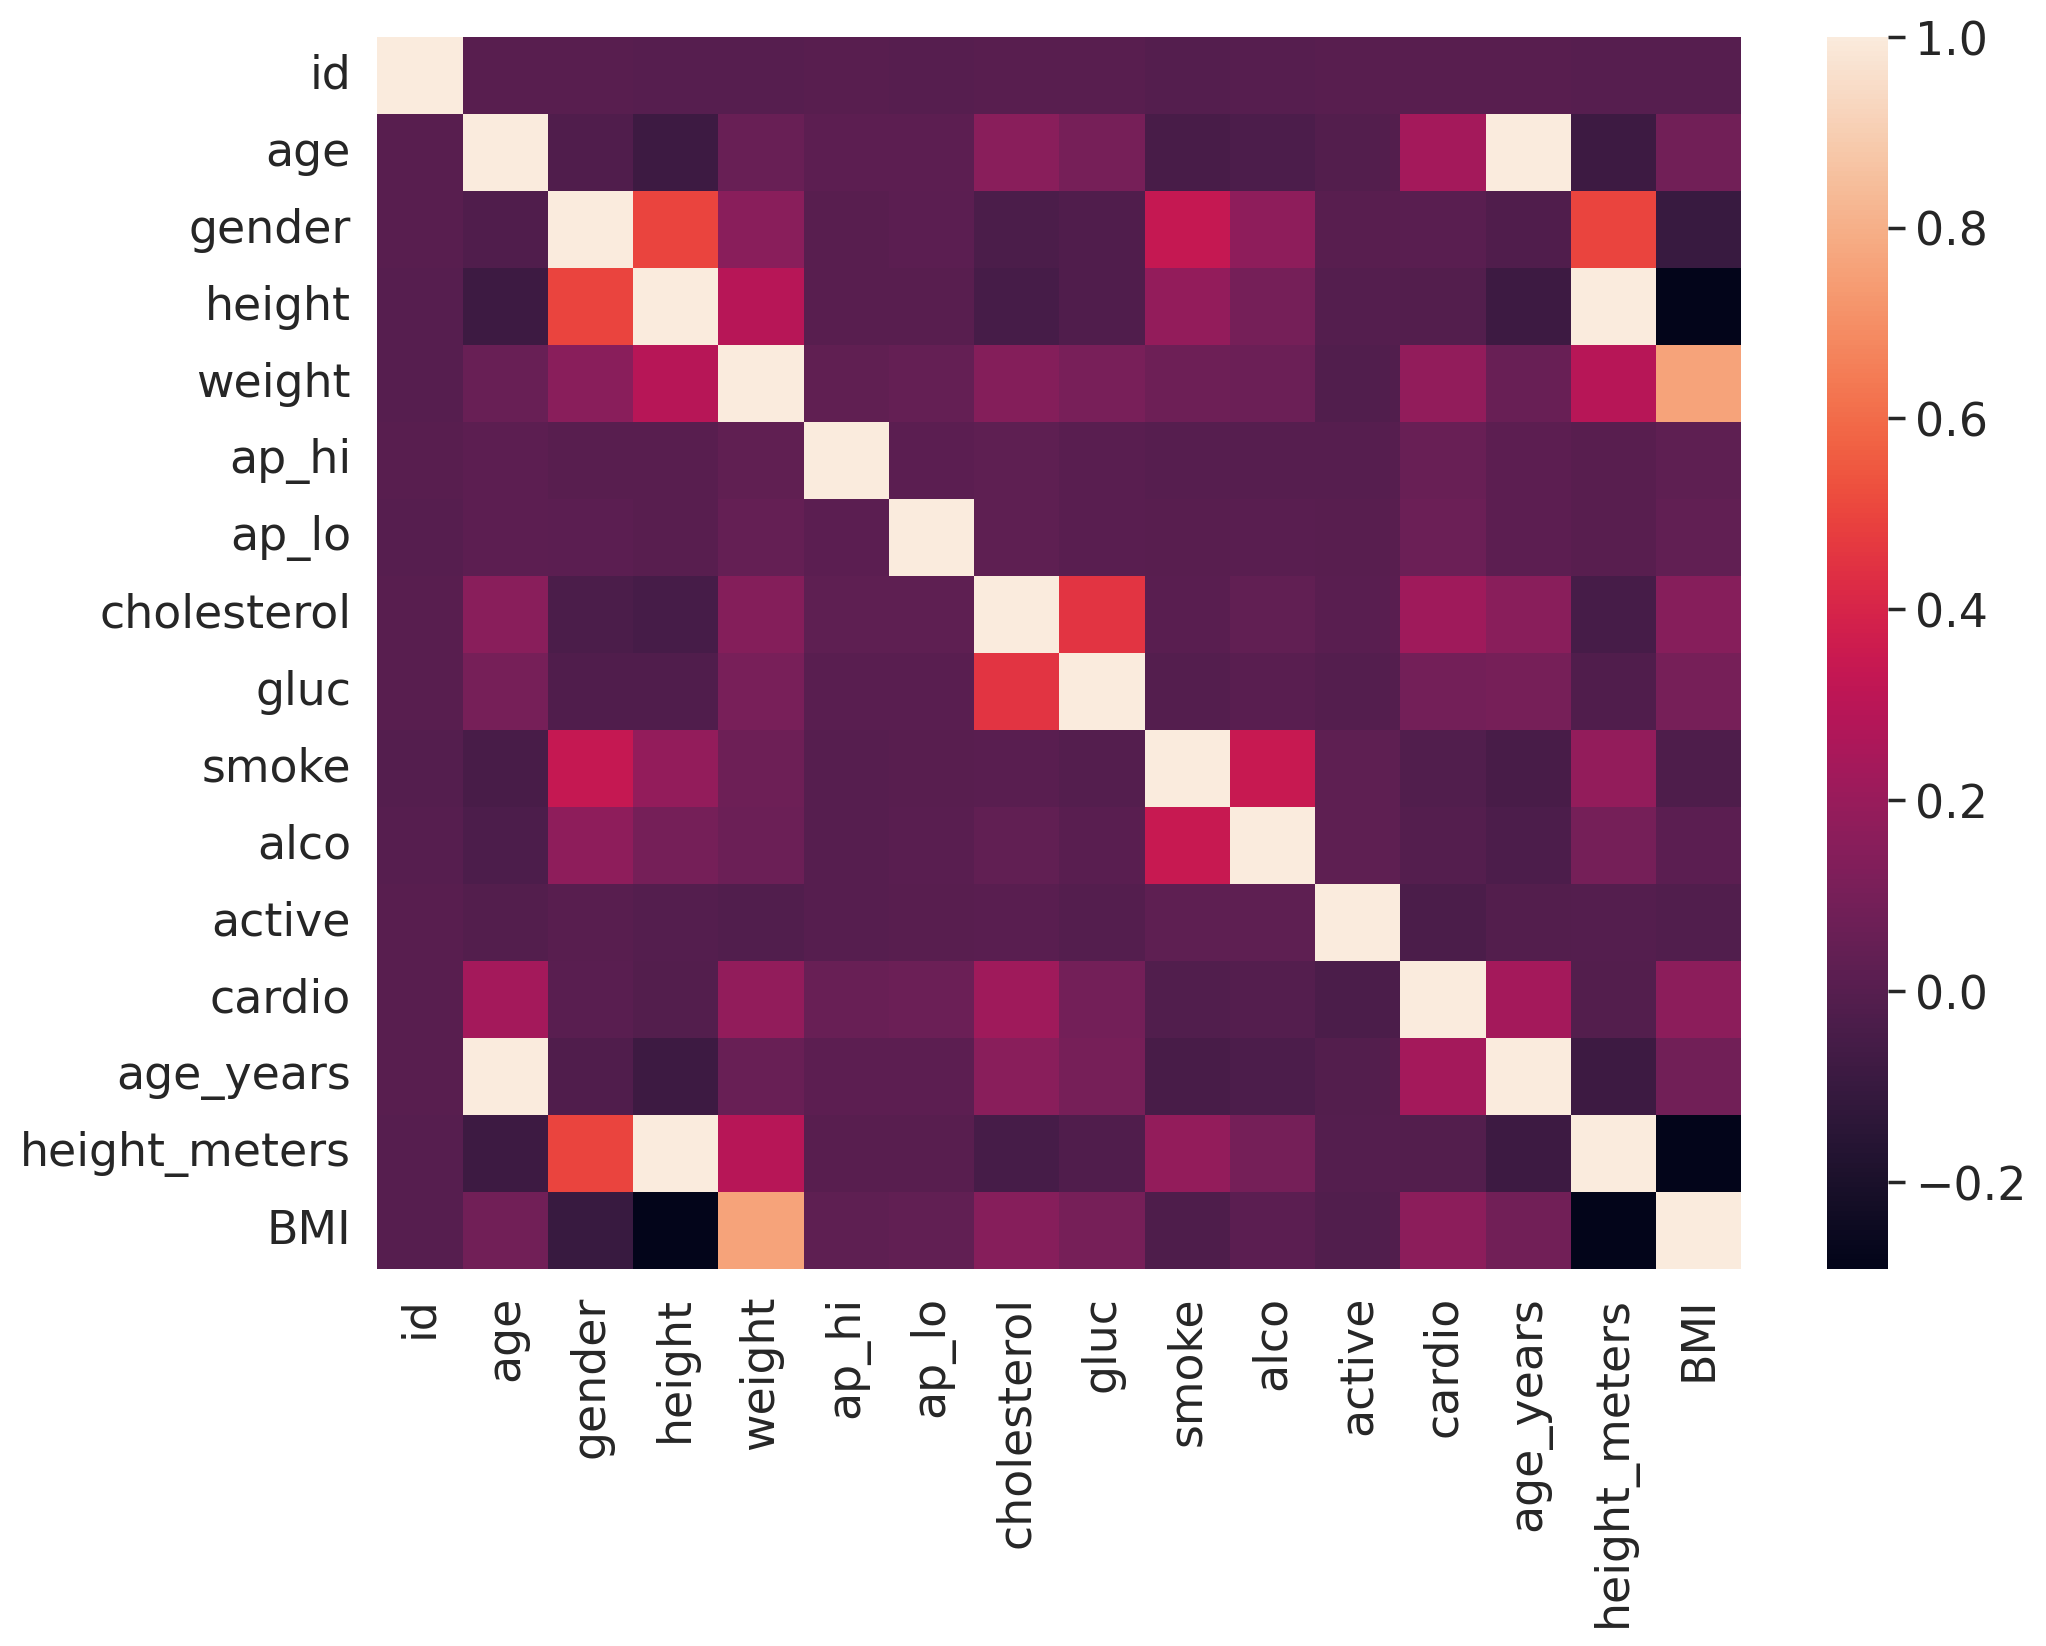

In [37]:
sns.heatmap(df.corr());

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

In [38]:
# ANSWER: 2

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

In [39]:
# Convert dataset to long format
df_melted = df.melt(id_vars=["gender"], value_vars=["height"], var_name="Feature", value_name="Value")

# Display first few rows
print(df_melted.head())

   gender Feature  Value
0       2  height    168
1       1  height    156
2       1  height    165
3       2  height    169
4       1  height    156


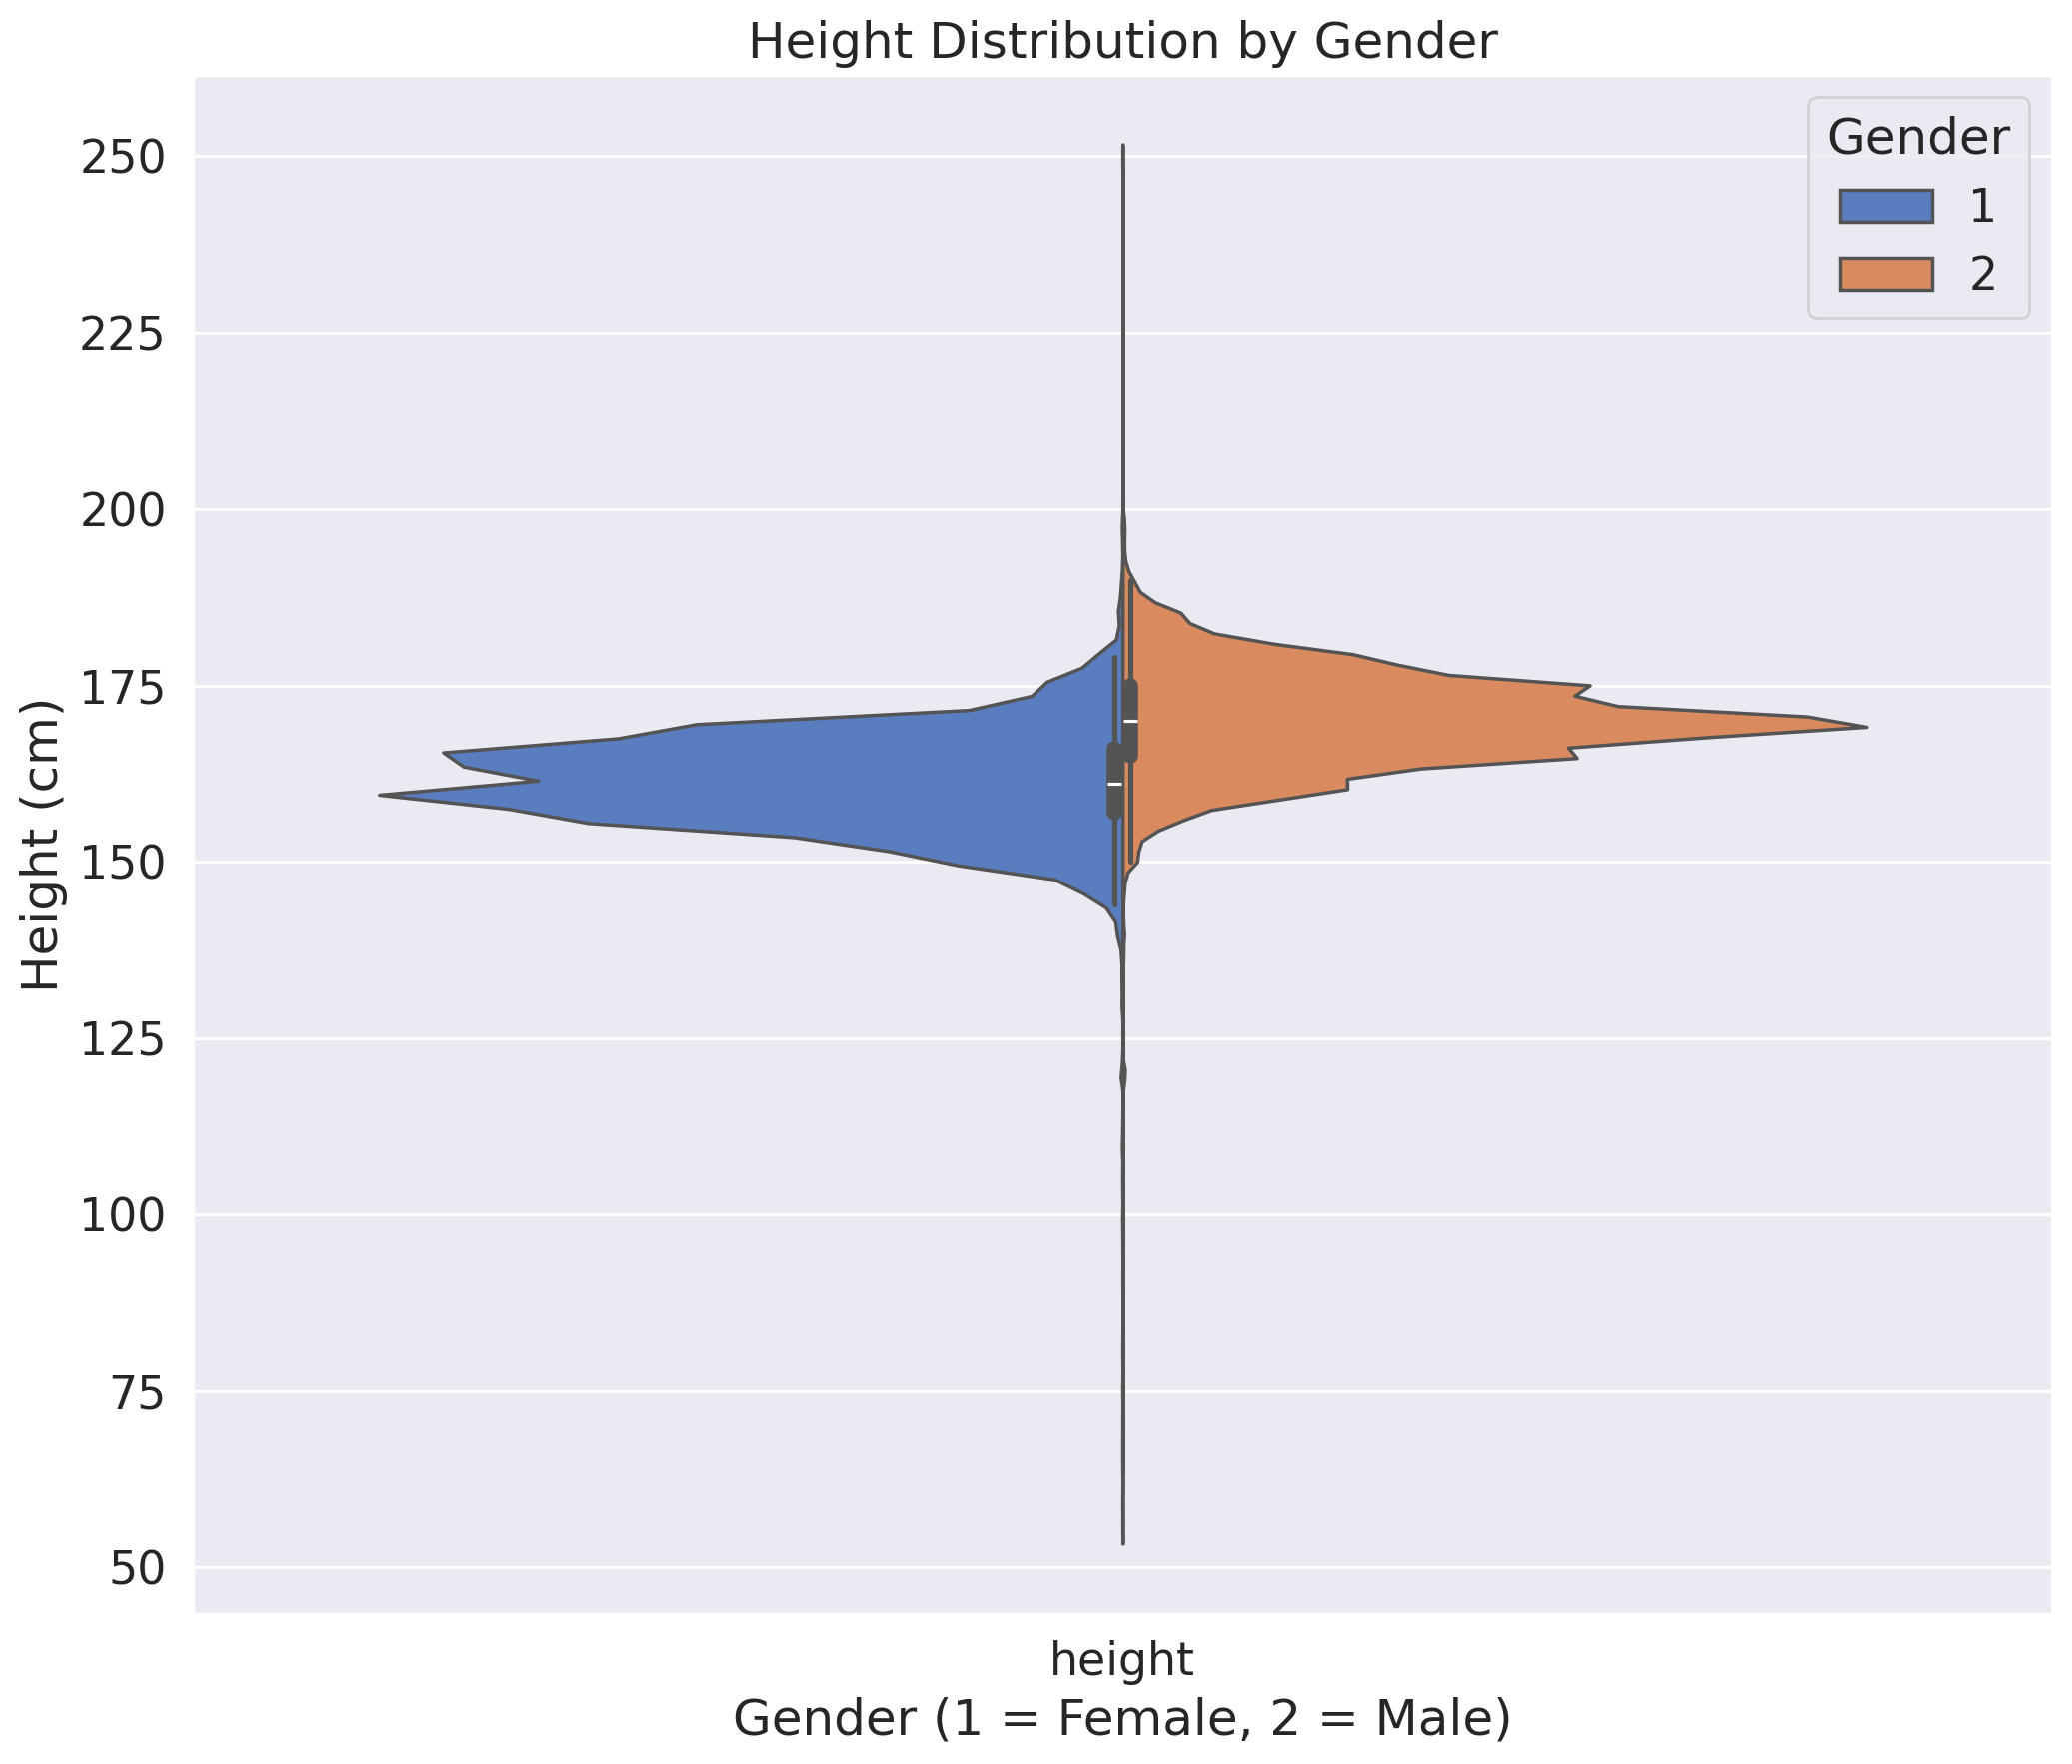

In [40]:
df_melt = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])


plt.figure(figsize=(12,10))
ax = sns.violinplot(
       x="variable",
        y="value",
        hue="gender",
        palette="muted",
        split=True,
        data=df_melt,
        scale="count",
        scale_hue=False,
)

# Customize plot
plt.xlabel("Gender (1 = Female, 2 = Male)")
plt.ylabel("Height (cm)")
plt.title("Height Distribution by Gender")
plt.legend(title="Gender")

# Show plot
plt.show()


**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

In [41]:
# had to find what spearman correlation was... use .corr() to find
spearman_corr = df.corr(method="spearman")
print(spearman_corr)


                     id       age    gender    height    weight     ap_hi  \
id             1.000000  0.002682  0.003506 -0.001886 -0.001292  0.003258   
age            0.002682  1.000000 -0.020176 -0.082292  0.061559  0.219087   
gender         0.003506 -0.020176  1.000000  0.533805  0.172480  0.063174   
height        -0.001886 -0.082292  0.533805  1.000000  0.313569  0.019381   
weight        -0.001292  0.061559  0.172480  0.313569  1.000000  0.277749   
ap_hi          0.003258  0.219087  0.063174  0.019381  0.277749  1.000000   
ap_lo         -0.000238  0.156700  0.066374  0.030534  0.254420  0.735436   
cholesterol    0.005706  0.140113 -0.035730 -0.058940  0.137908  0.208722   
gluc           0.002789  0.091791 -0.018866 -0.024369  0.109901  0.105334   
smoke         -0.003697 -0.047471  0.338135  0.197632  0.071676  0.028929   
alco           0.001214 -0.030078  0.170966  0.096670  0.068088  0.033243   
active         0.003766 -0.010422  0.005866 -0.007367 -0.014894 -0.001268   

In [42]:
# ANSWER Ap_hi, Ap_lo

## 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data. 
But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).



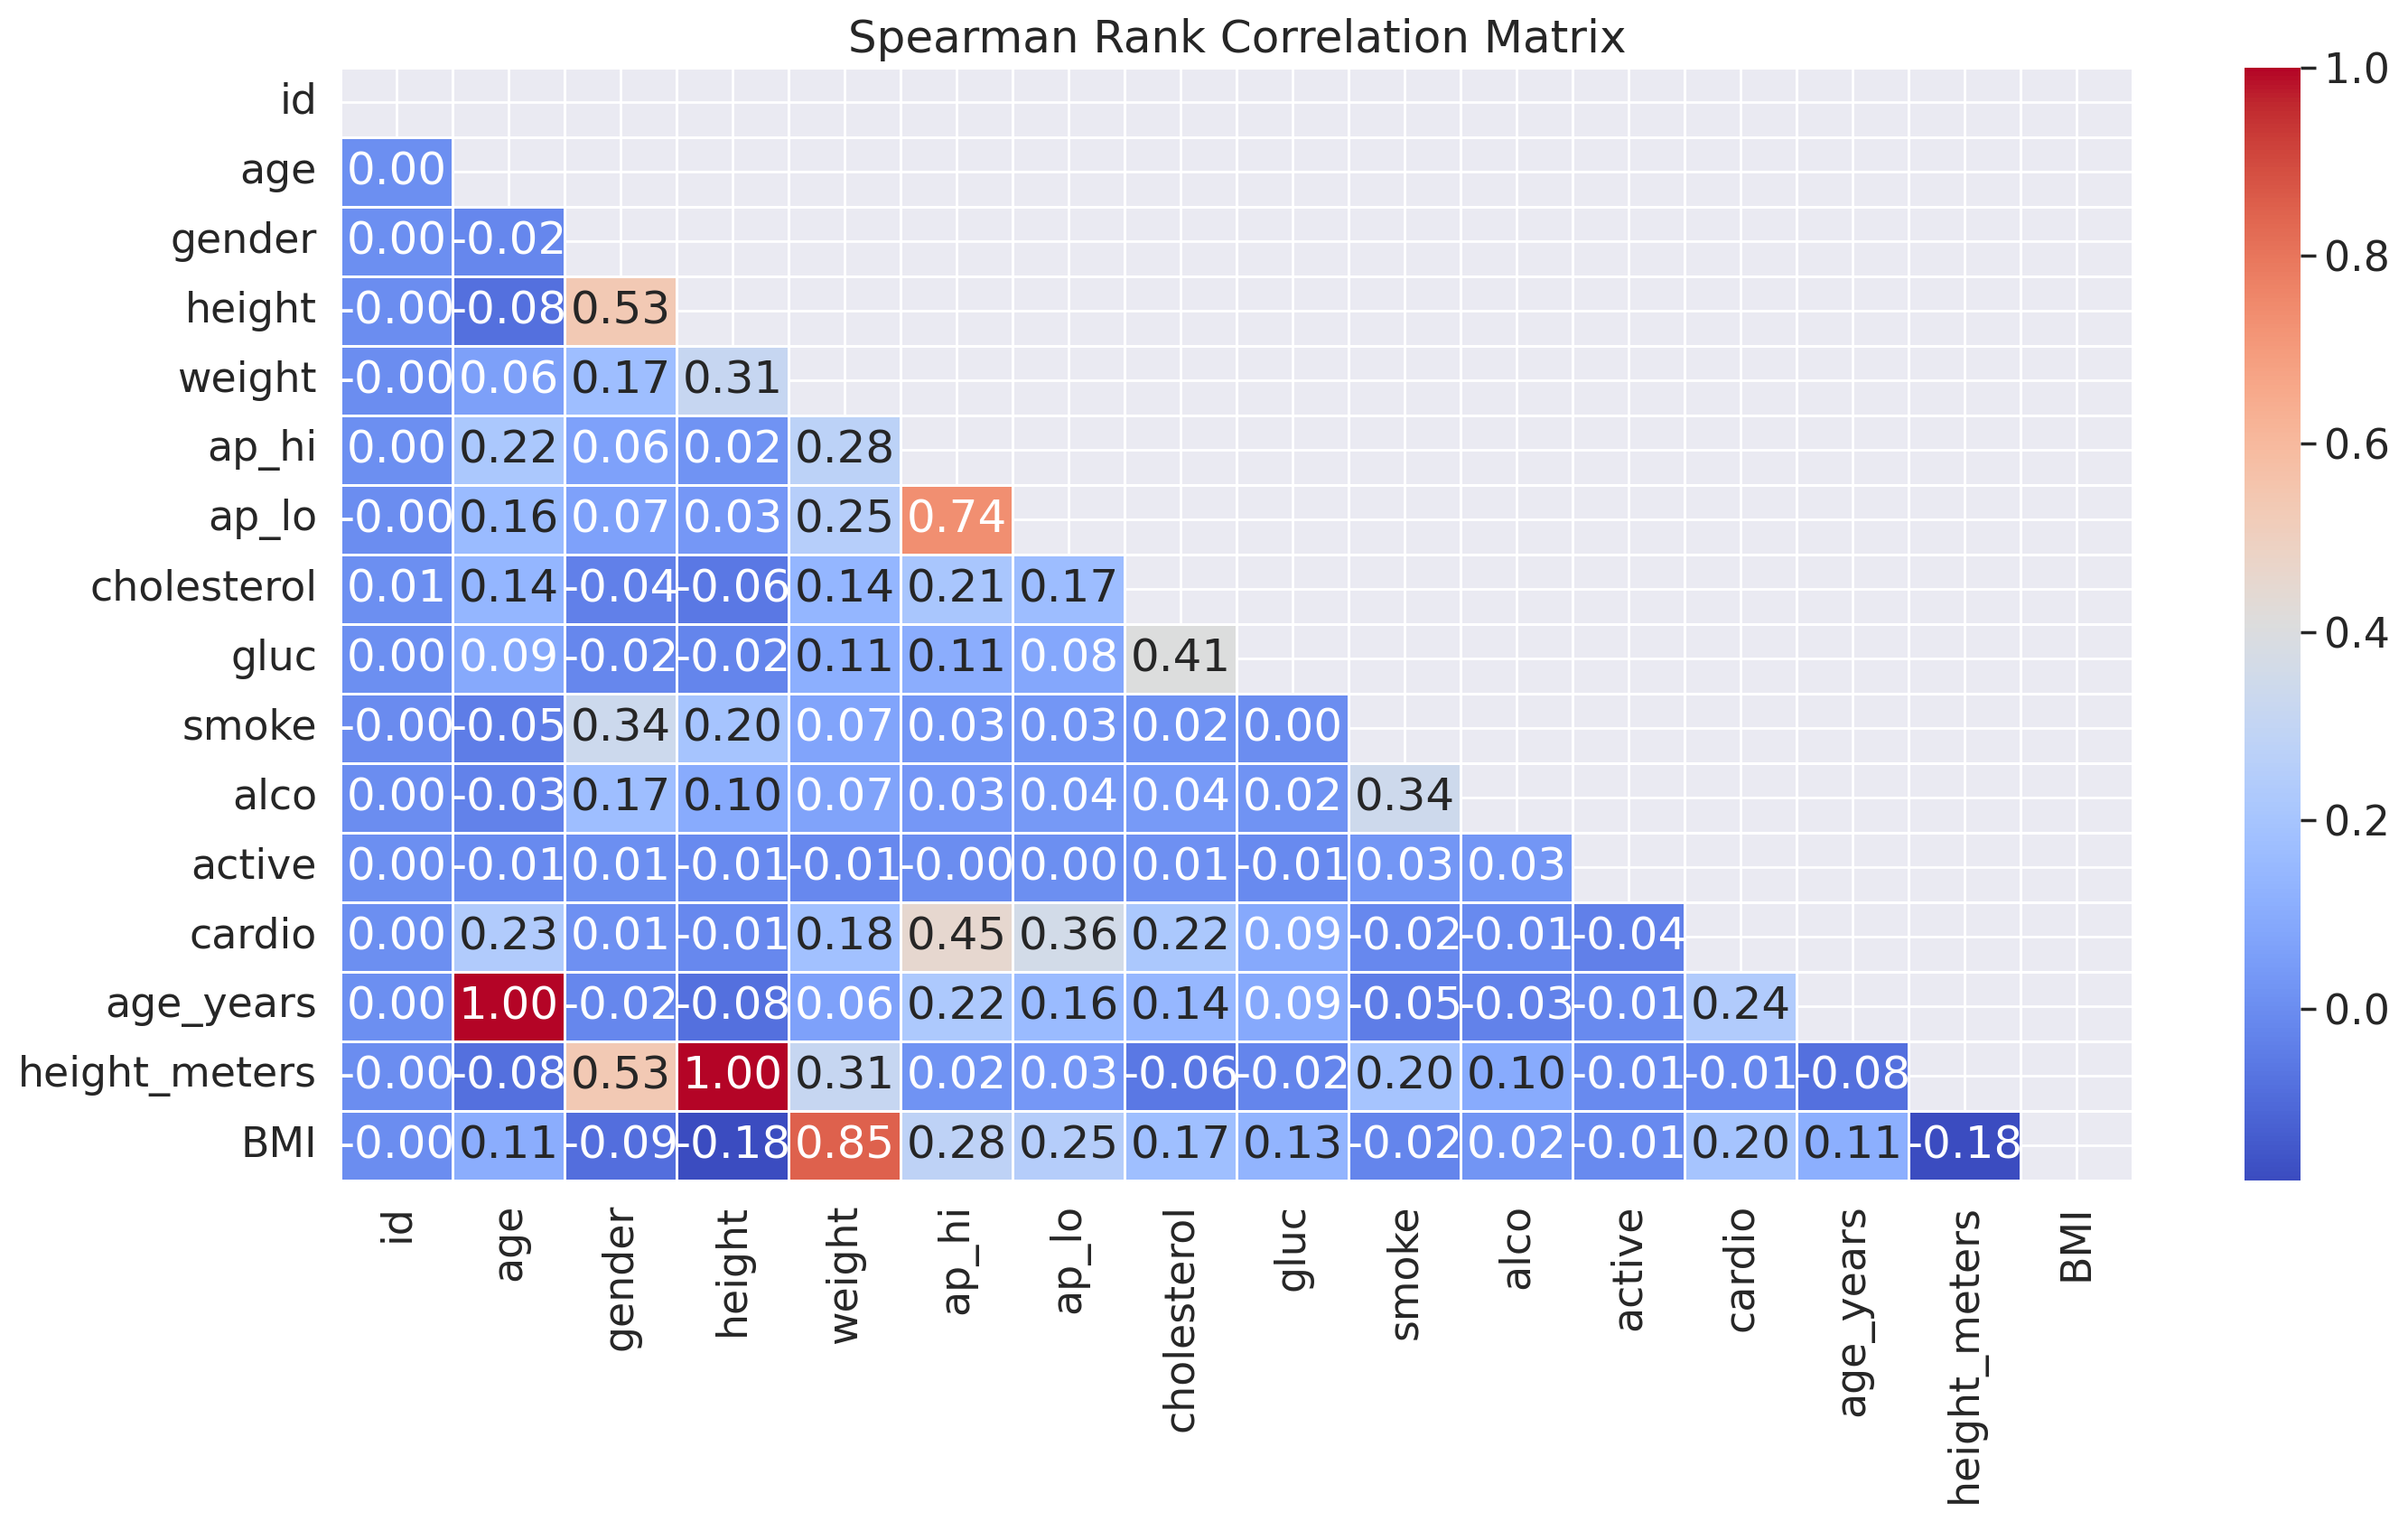

In [43]:
# Set figure size
plt.figure(figsize=(16, 8))

# Compute Spearman correlation matrix
spearman_corr = df.corr(method="spearman")

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(spearman_corr, dtype=bool))  # Creates a mask to hide upper triangle



# Create heatmap with a mask
sns.heatmap(
    spearman_corr, # the matric (from above)
    mask=mask,  # Apply the mask to hide the upper triangle
    annot=True,  # correlation values inside the matrix
    fmt=".2f",  # formatting
    cmap="coolwarm", # cool colors
    linewidths=0.5 # the lines between
)


# Title
plt.title("Spearman Rank Correlation Matrix")

# Show the plot
plt.show()


**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

In [44]:
# ANSWER 3. NATURE OF THE DATA

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

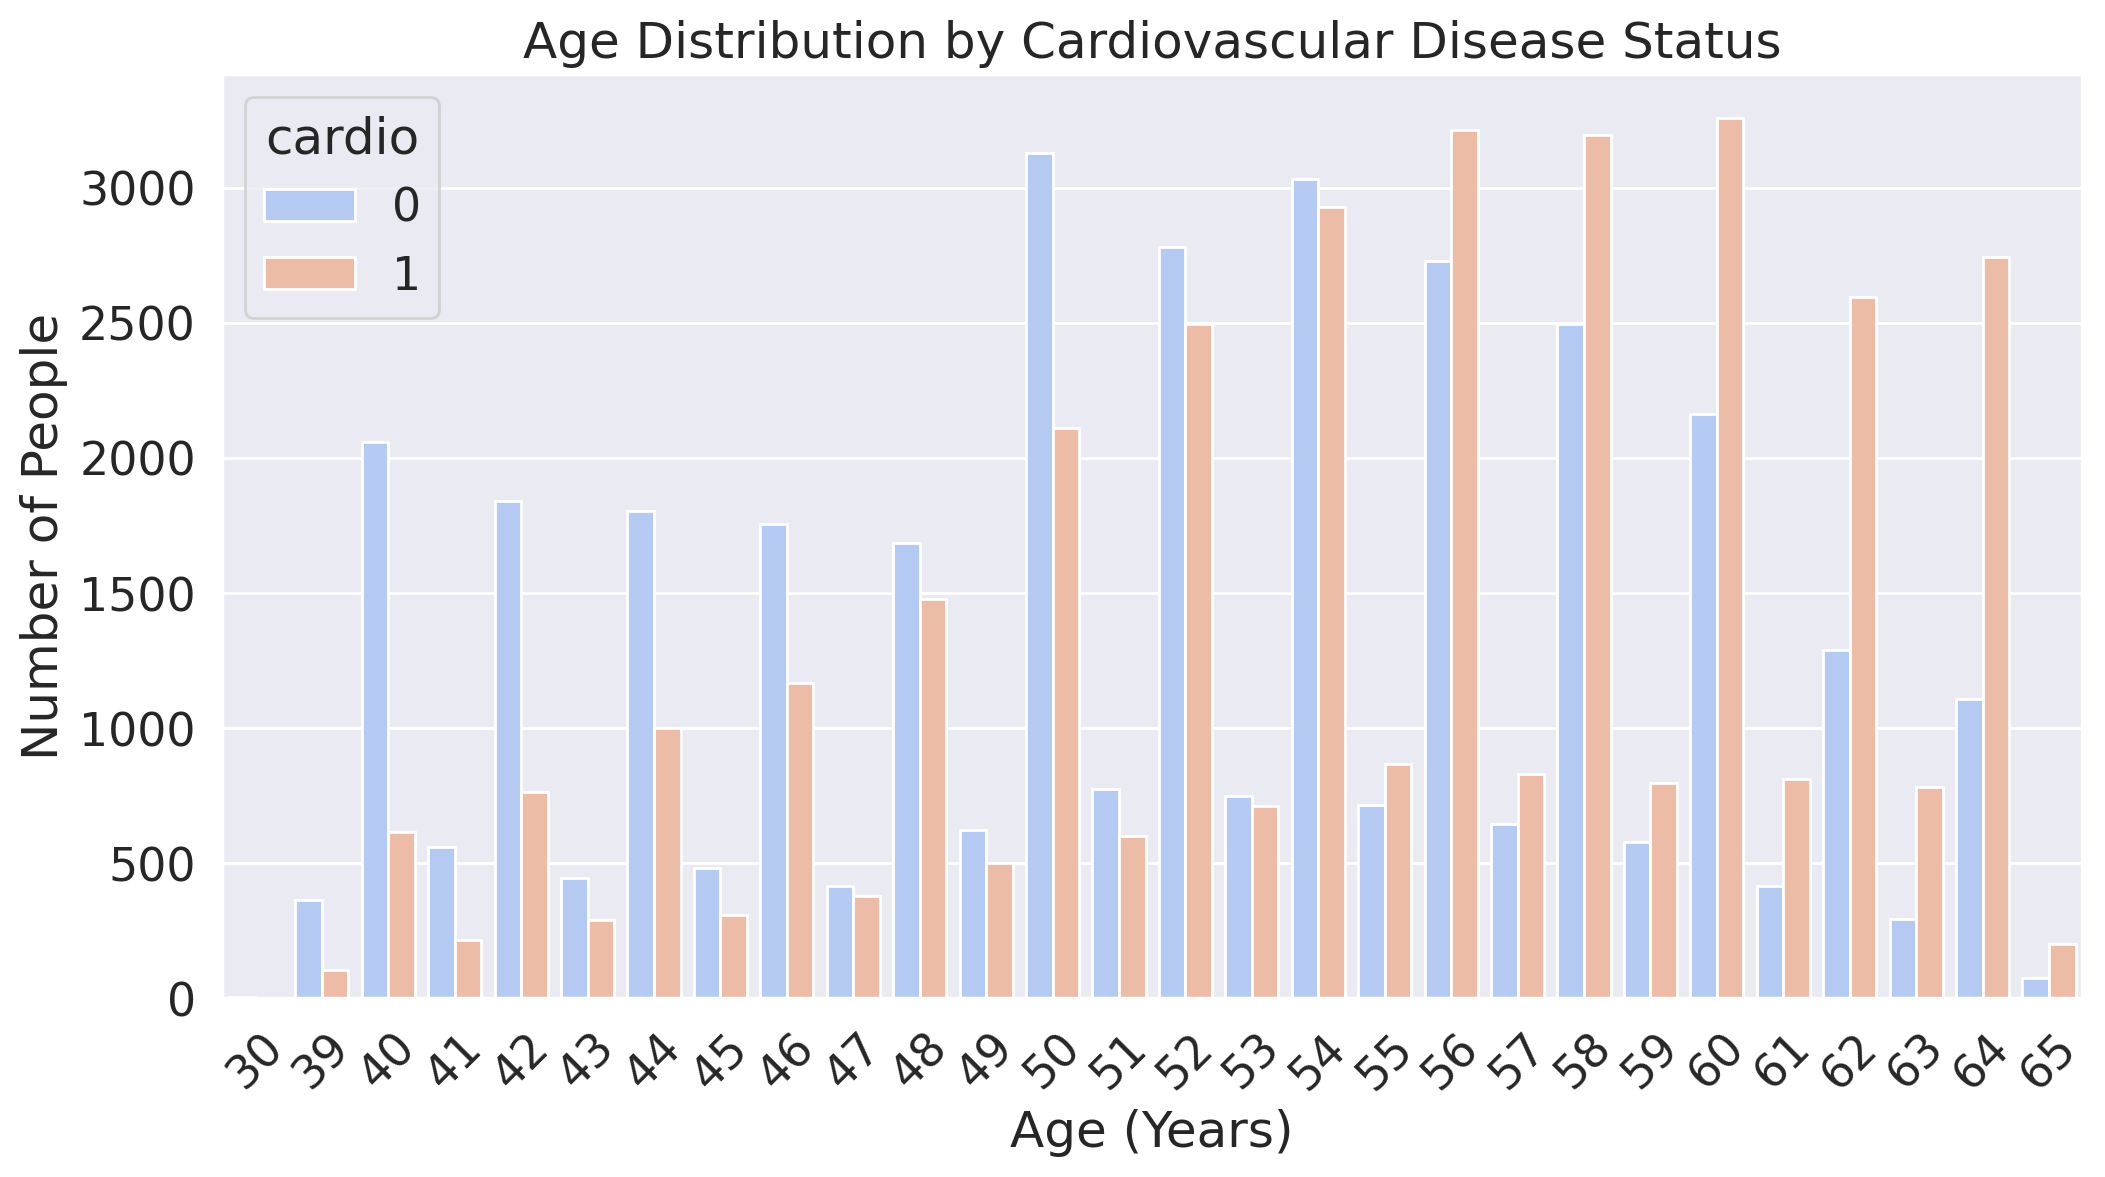

In [45]:
plt.figure(figsize=(12, 6))

# Create a count plot for age distribution
sns.countplot(
    x="age_years",  # Age in years on X-axis
    hue="cardio",  # Split bars by cardiovascular disease status (0 = No, 1 = Yes)
    data=df, 
    palette="coolwarm"  # Color scheme
)

# Customize labels
plt.xlabel("Age (Years)")
plt.ylabel("Number of People")
plt.title("Age Distribution by Cardiovascular Disease Status")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [46]:
# it appears to be 55, but I am going to verify with code
# Find the first age where CVD cases exceed non-CVD cases
df["age_years"] = (df["age"] / 365.25).astype(int)  # Convert from days to years

age_cardio_counts = df.groupby(["age_years", "cardio"]).size().unstack()
smallest_age = age_cardio_counts[age_cardio_counts[1] > age_cardio_counts[0]].index.min()

print(f"Smallest age where CVD cases outnumber non-CVD cases: {smallest_age}")

Smallest age where CVD cases outnumber non-CVD cases: 53


**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44
2. 55
3. 64
4. 70

In [47]:
# ANSWER = 55